# Royalty Prediction per Artist using XGBoost
## Master's Thesis in Data Science
### Autor: Florencia Federico
This analysis applies a XGBoost model, including exogenous variables such as social media followers and sentiment.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd

file_git = 'https://raw.githubusercontent.com/florfede/royalty-forecasting-timeseries/refs/heads/main/data/dataset.csv'
df = pd.read_csv(file_git)
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.head()

,artist_id,date,royalties,instagram_followers,twitter_followers,track_release,sentiment,mentions_followers,num_posts,num_comments,mean_royalties_6m,std_instagram_followers_6m,growth_twitter_followers,growth_instagram_followers,sum_track_releases_6m,mean_sentiment_3m,sum_mentions_followers_3m,month
0,436lvfnz,2022-07-01,94291.905,5250688,643908,1,0.649123,26326461,3,57,94291.90500,0.00000,0,0,1,0.649123,26326461,7
1,436lvfnz,2022-08-01,90967.300,5283706,647332,0,0.493088,26326461,7,217,92629.60250,23347.25170,3424,33018,1,0.571105,52652922,8
2,436lvfnz,2022-09-01,96849.325,5316966,648728,1,0.703297,0,5,91,94036.17667,33139.07363,1396,33260,2,0.615169,52652922,9
3,436lvfnz,2022-10-01,94944.180,5346661,649390,0,0.548611,50734,5,144,94263.17750,41478.03735,662,29695,2,0.581665,26377195,10
4,436lvfnz,2022-11-01,93308.900,5403544,649732,1,0.557554,26326461,10,278,94072.32200,58780.37927,342,56883,3,0.603154,26377195,11


In [3]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm.notebook import tqdm

results = []
predictions_output = []

for artist_id, group in tqdm(df.groupby("artist_id")):
    group = group.sort_values("date")

    if len(group) < 10:
        continue

    X = group[[
        "instagram_followers", "twitter_followers", "track_release", "sentiment",
        "mentions_followers", "num_posts", "num_comments", "mean_royalties_6m",
        "std_instagram_followers_6m", "growth_twitter_followers", "growth_instagram_followers",
        "sum_track_releases_6m", "mean_sentiment_3m", "sum_mentions_followers_3m", "month"
    ]]
    y = group["royalties"]
    dates = group["date"]

    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    dates_train, dates_test = dates[:train_size], dates[train_size:]

    model = XGBRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    forecast = model.predict(X_test)

    mse = mean_squared_error(y_test, forecast)
    mae = mean_absolute_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, forecast)

    results.append({
        "Artist_ID": artist_id,
        "Model": "XGBoost",
        "MSE": mse,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE": mape
    })

    for d, real, pred in zip(dates_test, y_test, forecast):
        predictions_output.append({
            "artist_id": artist_id,
            "date": d,
            "royalties_actual": real,
            "royalties_predicted": pred,
            "model": "XGBoost"
        })


  0%|          | 0/15 [00:00<?, ?it/s]

In [4]:
df_results = pd.DataFrame(results)
df_results.to_csv("xgboost_metrics_per_artist.csv", index=False)

df_preds = pd.DataFrame(predictions_output)
#df_preds.to_csv("xgboost_predicciones_para_powerbi.csv", index=False)
df_results.head()

,Artist_ID,Model,MSE,MAE,RMSE,MAPE
0,436lvfnz,XGBoost,1.325004e+09,33822.949955,36400.602766,0.207862
1,5jwhbt0o,XGBoost,2.602733e+07,3250.645285,5101.698870,0.281256
2,5t4iv6o3,XGBoost,2.205998e+09,45620.152857,46968.057323,0.134839
3,65m1vtnc,XGBoost,1.162065e+10,92208.587222,107799.106415,0.130734
4,67gc5xm9,XGBoost,3.274677e+09,49809.278056,57224.791576,0.124911


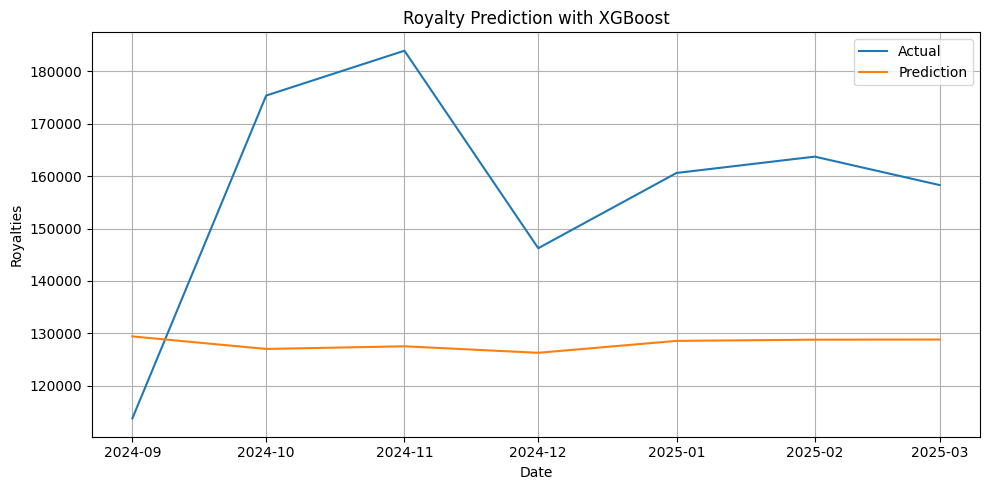

In [5]:
import matplotlib.pyplot as plt

example = df_preds[df_preds["artist_id"] == df_preds["artist_id"].unique()[0]]
plt.figure(figsize=(10,5))
plt.plot(example["date"], example["royalties_actual"], label="Actual")
plt.plot(example["date"], example["royalties_predicted"], label="Prediction")
plt.title("Royalty Prediction with XGBoost")
plt.xlabel("Date")
plt.ylabel("Royalties")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Forecast

XGBoost does not naturally predict future time steps like Prophet or SARIMAX.
It is usually used in one of two ways:

* Rolling Prediction: predict one month ahead, add the prediction to the dataset, then use it to predict the next month, and so on.
* Batch Prediction: if you already have all the future independent variables (e.g., month, year, future sentiment, future releases), you can predict multiple steps at once.
(However, this is rarely the case in real-world forecasting.)

In our case, rolling prediction is the appropriate approach:

1. We predict the first month using the most recent available data.
2. We use that first forecast as input to predict the second month.
3. We repeat the process iteratively until reaching the 6-month horizon.

In [6]:
def forecast_xgboost_per_artist(df, artist_id, steps=6):
    """
    Trains an XGBoost model per artist and performs a 6-month rolling forecast.

    Parameters:
    - df: General DataFrame
    - artist_id: Artist ID
    - steps: Number of months to forecast

    Returns:
    - forecast_df: DataFrame with predictions
    - fig: Plot
    """
    # Filter data
    df_artist = df[df['artist_id'] == artist_id].copy()
    df_artist = df_artist.sort_values('date')

    # Ensure proper datetime format
    df_artist['date'] = pd.to_datetime(df_artist['date'])
    df_artist = df_artist.set_index('date').asfreq('MS')

    # Create date-related variables (month, year)
    df_artist['month'] = df_artist.index.month
    df_artist['year'] = df_artist.index.year

    # Independent variables (features) and target
    X = df_artist[['month', 'year']]
    y = df_artist['royalties']

    # Train model
    model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X, y)

    # Rolling forecast
    forecasts = []
    last_date = df_artist.index[-1]
    last_month = last_date.month
    last_year = last_date.year

    for _ in range(steps):
        # Calculate next month and year
        if last_month == 12:
            next_month = 1
            next_year = last_year + 1
        else:
            next_month = last_month + 1
            next_year = last_year

        # Create input
        X_pred = pd.DataFrame({'month': [next_month], 'year': [next_year]})

        # Predict
        y_pred = model.predict(X_pred)[0]

        # Save prediction
        pred_date = last_date + pd.DateOffset(months=1)
        forecasts.append({
            'artist_id': artist_id,
            'prediction_date': pred_date,
            'royalties_forecast': y_pred
        })

        # Update "last date"
        last_date = pred_date
        last_month = last_date.month
        last_year = last_date.year

        # (Optional) We could add the prediction to training to better simulate reality, but we'll keep it simple.

    forecast_df = pd.DataFrame(forecasts)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 5))
    y.plot(ax=ax, label='Historical')
    forecast_df.set_index('prediction_date')['royalties_forecast'].plot(ax=ax, label='Forecast', color='orange')
    ax.set_title(f'XGBoost Forecast - Artist {artist_id}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Royalties')
    ax.legend()
    plt.tight_layout()
    plt.close(fig)

    return forecast_df, fig


In [7]:
# List of artists
artist_list = df['artist_id'].unique()

# Store results
forecast_list = []
figure_list = []

# Loop
for artist_id in artist_list:
    forecast_df, figure = forecast_xgboost_per_artist(df, artist_id, steps=6)
    forecast_list.append(forecast_df)
    figure_list.append((artist_id, figure))

# Consolidate forecasts
consolidated_forecasts_df = pd.concat(forecast_list, ignore_index=True)


Forecast chart for artist 436lvfnz


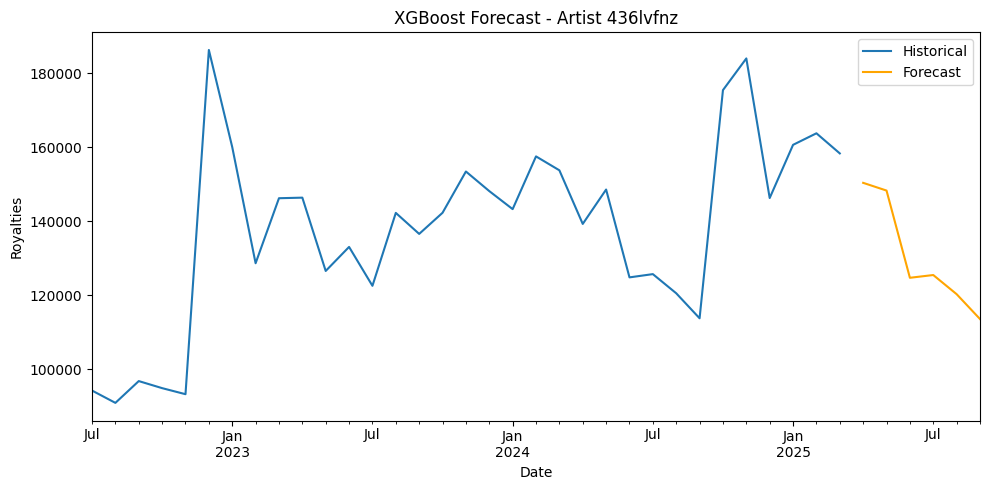

Forecast chart for artist 5jwhbt0o


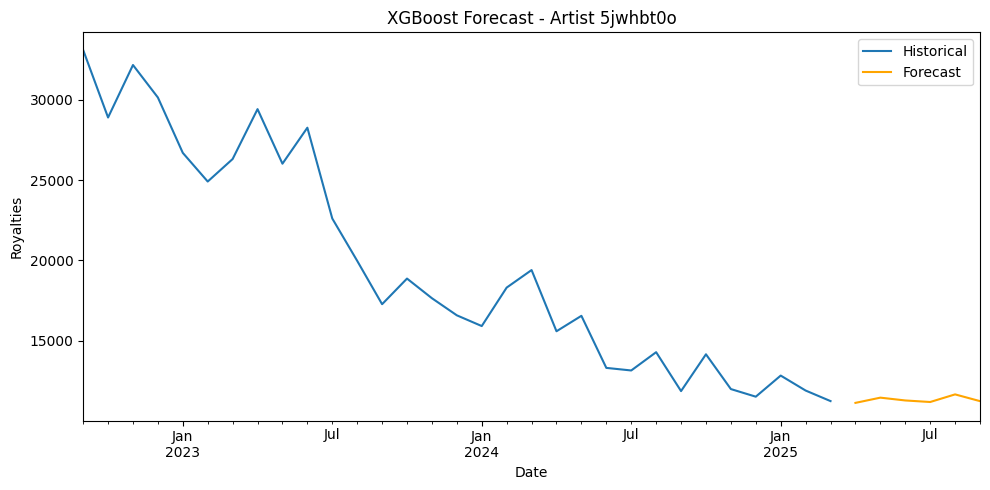

Forecast chart for artist 5t4iv6o3


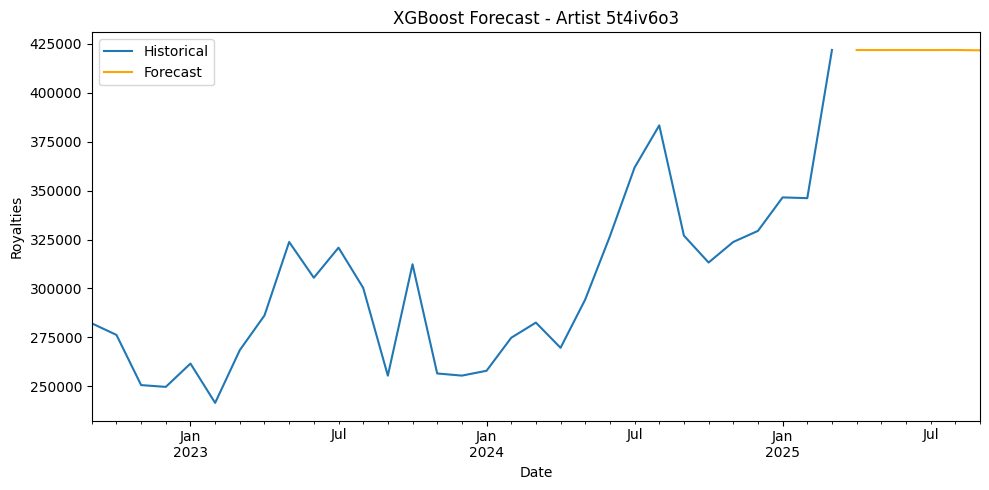

Forecast chart for artist 65m1vtnc


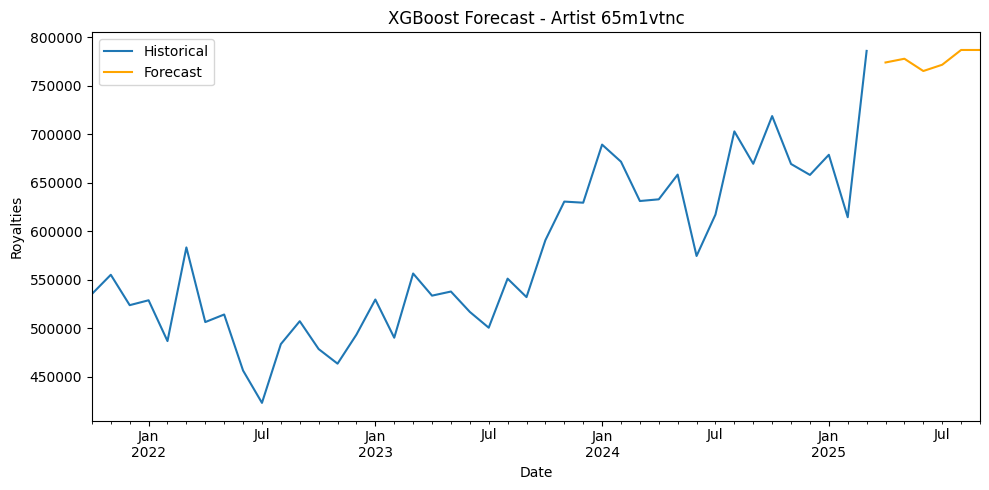

Forecast chart for artist 67gc5xm9


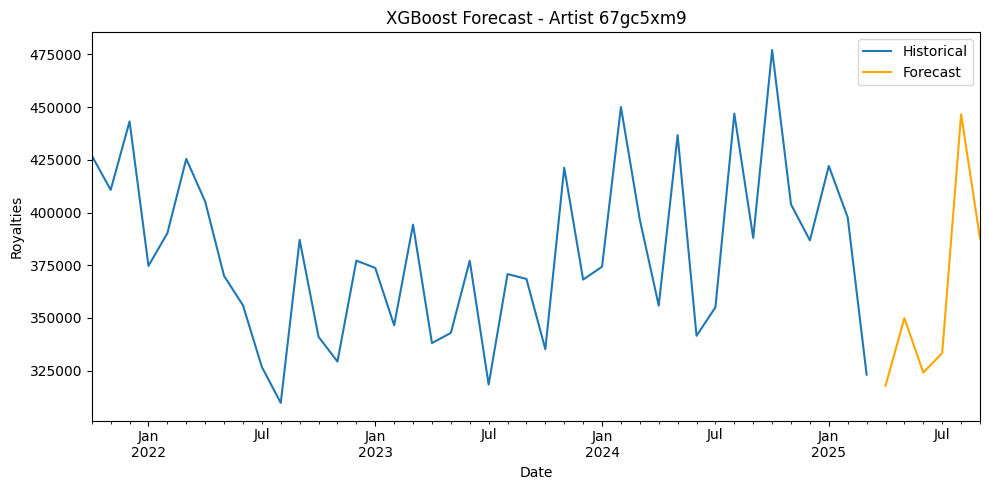

Forecast chart for artist 6ygz70qs


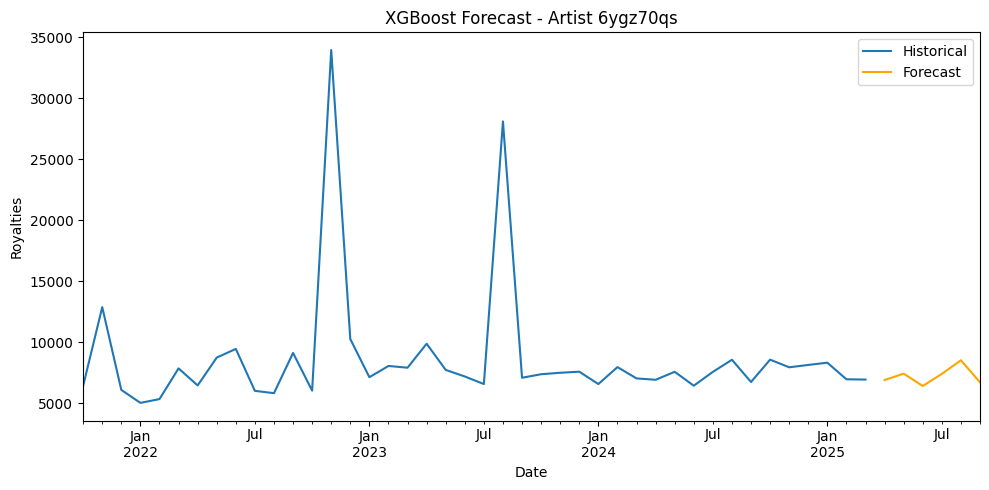

Forecast chart for artist al0gcvtm


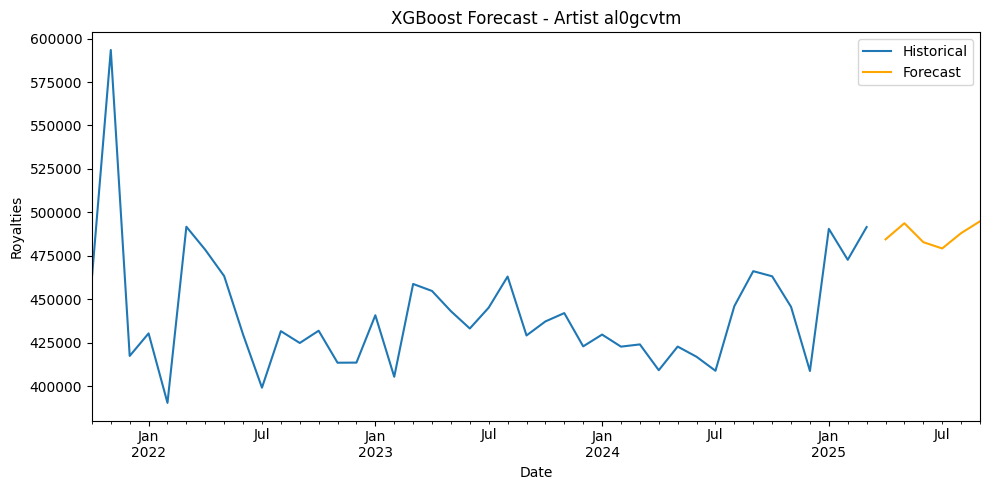

Forecast chart for artist awrkf92m


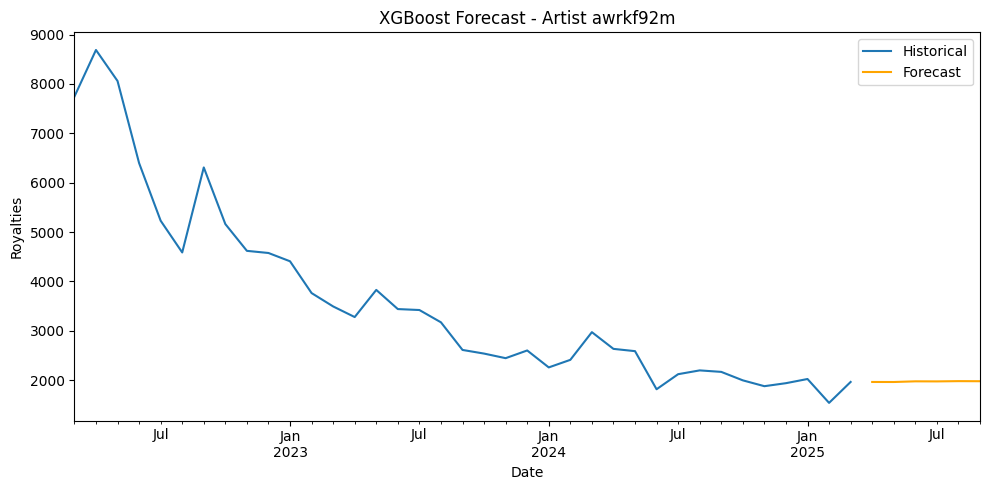

Forecast chart for artist bpgx7194


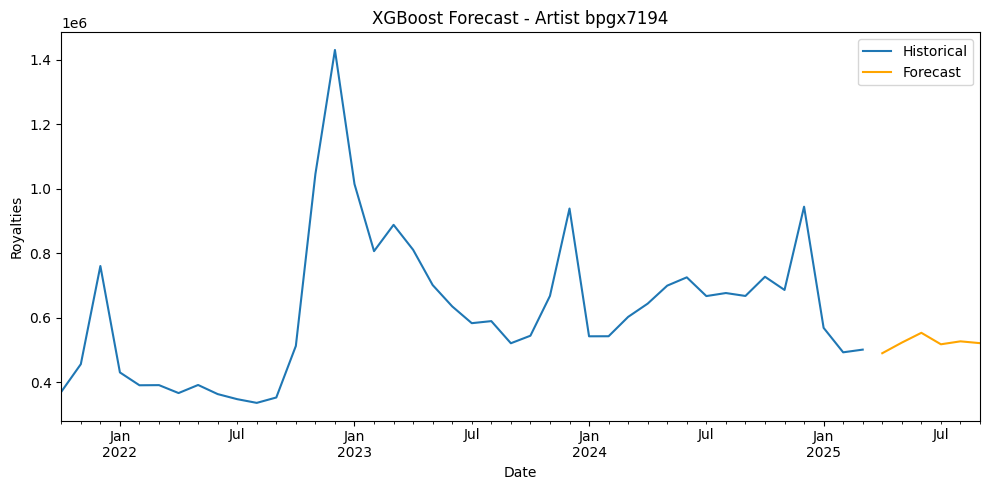

Forecast chart for artist hfiatnv8


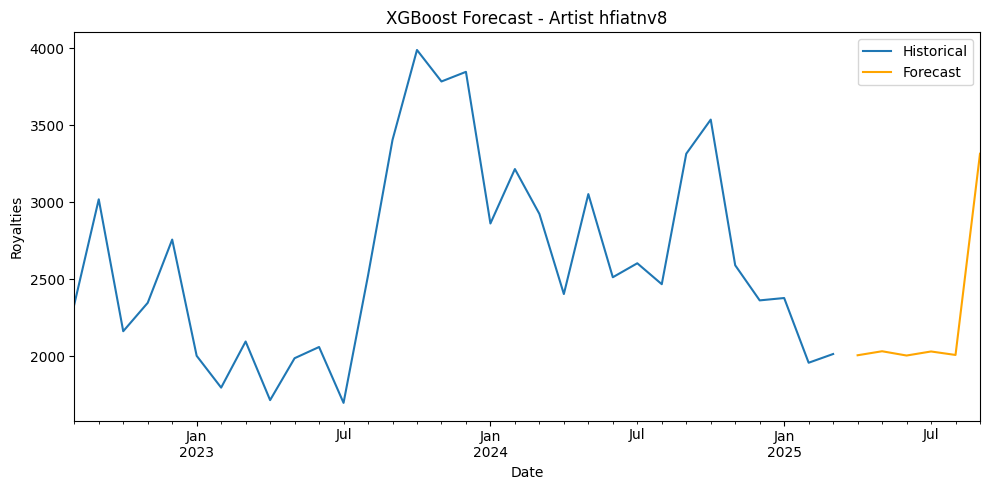

Forecast chart for artist jla6nu3p


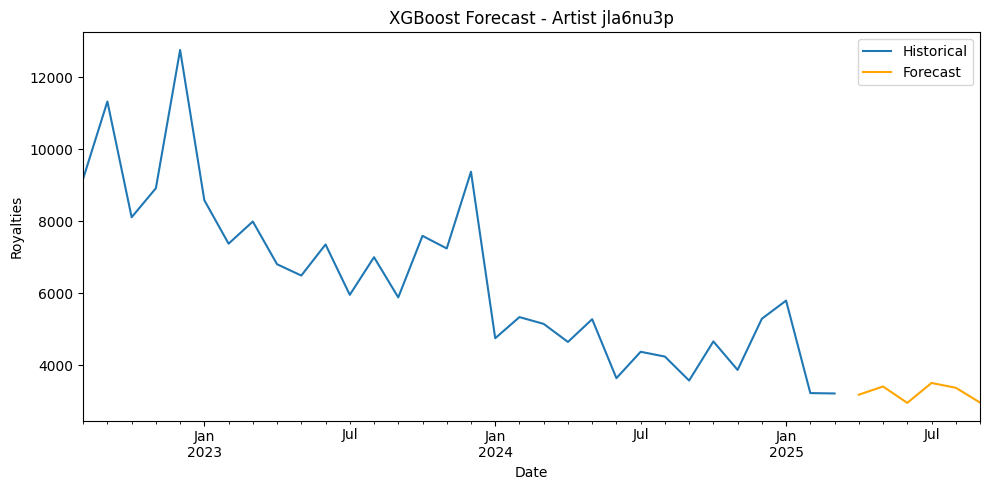

Forecast chart for artist k74pw1av


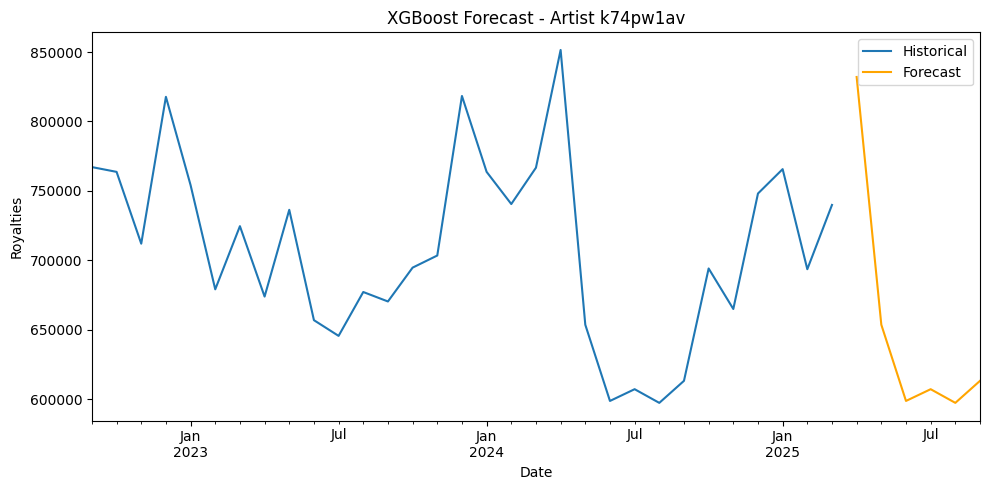

Forecast chart for artist kcw3uapo


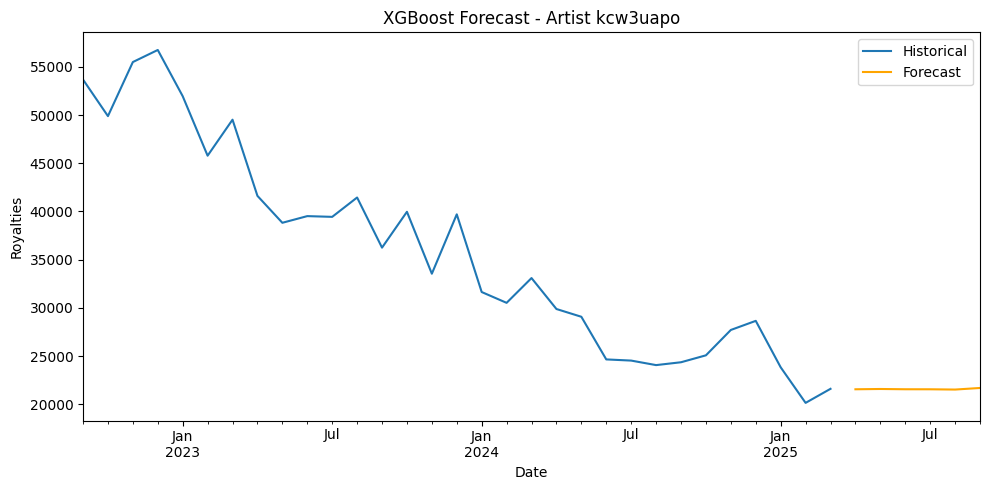

Forecast chart for artist pymr5w10


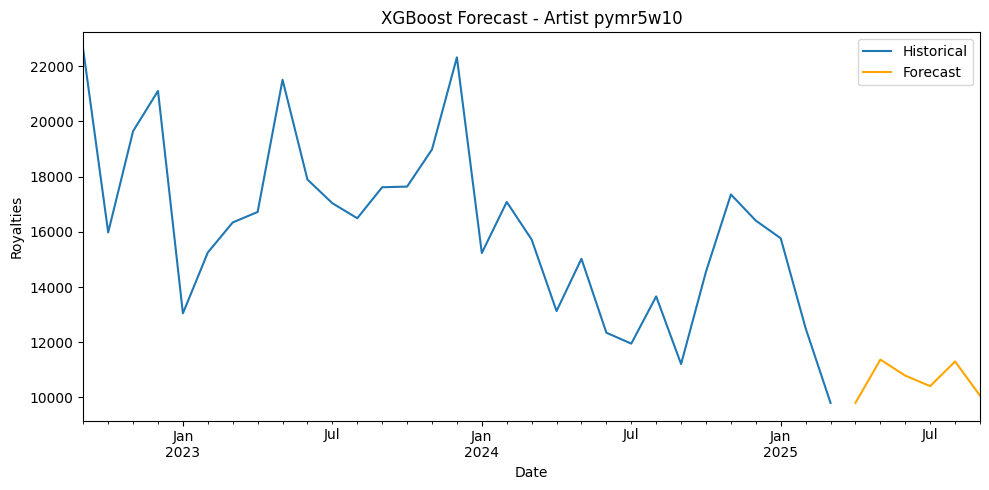

Forecast chart for artist r976ytqo


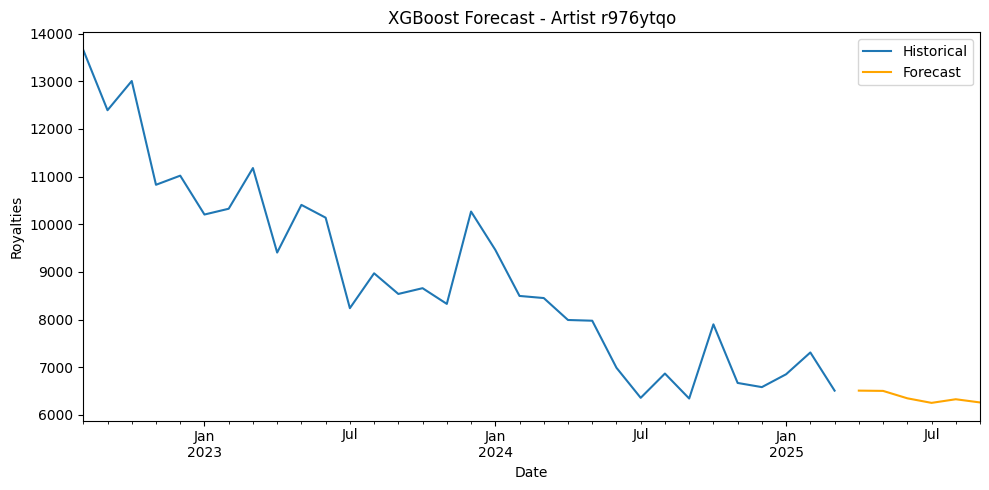

In [8]:
# Display forecast charts
for artist_id, figure in figure_list:
    print(f"Forecast chart for artist {artist_id}")
    display(figure)
